#  Project: Image Captioning


---

## Problem Statement: 
Annotate an image with a short description explaining the contents in that image.

**Dataset used:** 
The Microsoft **C**ommon **O**bjects in **CO**ntext (MS COCO) dataset is a large-scale dataset for scene understanding.  The dataset is commonly used to train and benchmark object detection, segmentation, and captioning algorithms.  


You can read more about the dataset on the [website](http://cocodataset.org/#home) or in the [research paper](https://arxiv.org/pdf/1405.0312.pdf).

## Project Planning

### The project is divided into the following tasks and, each task is carried out in it's respective Jupyter Notebook.
 1. Dataset Exploration: In this notebook, the COCO dataset is explored, in preparation for the project.
 2. Preprocessing: In this notebook, COCO dataset is loaded and pre-processed, making it ready to pass to the model for training.
 3. Training: In this notebook, the CNN-RNN deep architecture model is trained.
 4. **Inference: In this notebook, the trained model is used to generate captions for images in the test dataset. Here, the performance of the model is observed on real world images.**

## Task Planning:

- [Step 1](#step1): Data Loader for Test Dataset 
- [Step 2](#step2): Loading Trained Models
- [Step 3](#step3): Finishing the Sampler
- [Step 4](#step4): Cleaning up Captions
- [Step 5](#step5): Generating Predictions!

### Imports

In [ ]:
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import os
from model import EncoderCNN, DecoderRNN

<a id='step1'></a>
## Step 1: Data Loader for Test Dataset

Creating a Data Loader for Testing Data that is similar to the one created for Training Data

In [1]:
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.486, 0.406),
                         (0.229, 0.224, 0.225))])

# Creating the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


torch.Size([1, 612, 612, 3])
torch.Size([1, 3, 224, 224])


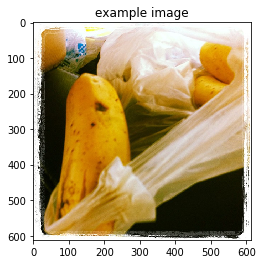

In [2]:
# Let's visualize a test image before and after Preprocessing

orig_image, image = next(iter(data_loader))

# Visualizing sample image, before pre-processing.
print(orig_image.shape)
print(image.shape)
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

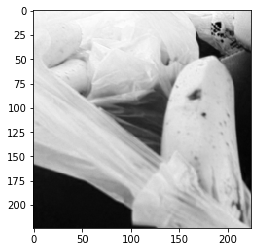

In [3]:
# After transforming
image_np = image.numpy()
plt.imshow(np.squeeze(image_np)[0], cmap='gray') # Random Horizontal Flip

<a id='step2'></a>
## Step 2: Loading Trained Models


In [4]:
# Moving PyTorch tensors to GPU (if CUDA is available).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
# Watching for any changes in model.py, and re-load it automatically.
% load_ext autoreload
% autoreload 2

# Specifying the saved models to load for testing purposes.
encoder_file = 'encoder-3.pkl'
decoder_file = 'decoder-3.pkl'

# Selecting appropriate values for the Python variables below(Same as those during Training).
embed_size = 256
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initializing the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Loading the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

# Moving models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (embed): Embedding(7525, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (fc1): Linear(in_features=512, out_features=7525, bias=True)
)

<a id='step3'></a>
## Step 3: Finishing the Sampler

- Here, I'm using the `sample` method in the DecoderRNN class in `model.py`. This method accepts as input a PyTorch tensor features containing the embedded input features corresponding to a single image.
- It returns a Python list `output`, indicating the predicted sentence. output[i] is a nonnegative integer that identifies the predicted i-th token in the sentence.
- The correspondence between integers and tokens can be explored by examining either `data_loader.dataset.vocab.word2idx` (or `data_loader.dataset.vocab.idx2word`).


In [7]:
# Moving image Pytorch Tensor to GPU.
image = image.to(device)

# Obtaining the embedded image features.
features = encoder(image).unsqueeze(1)

# Passing the embedded image features through the Decoder to get a caption.
print(f"Size of features: {features.shape}")
output = decoder.sample(features)
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

Size of features: torch.Size([1, 1, 256])
example output: [0, 3, 832, 6, 3, 832, 38, 3, 111, 18, 1]


In [15]:
print(f"Size of features: {features.shape}")

Size of features: torch.Size([1, 1, 256])


<a id='step4'></a>
## Step 4: Cleaning up the Captions

Creating a function that decodes a list of integers to a sentence of words, which is our caption for the image.

In [8]:
def clean_sentence(output):
    words = [data_loader.dataset.vocab.idx2word[x] for x in output][1:-1]
    print(words)
    sentence = " ".join(words)
    return sentence

In [9]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence: a banana and a banana on a table .


<a id='step5'></a>
## Step 5: Generating Predictions!


In [10]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

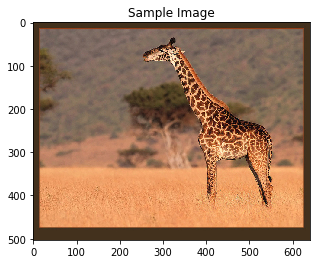

a giraffe standing in a field with trees in the background .


In [14]:
get_prediction()

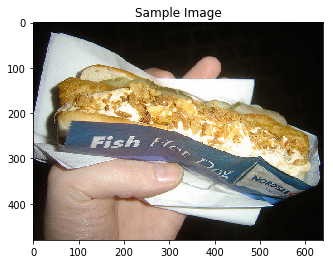

a person holding a piece of paper with a half eaten sandwich .


In [15]:
get_prediction()

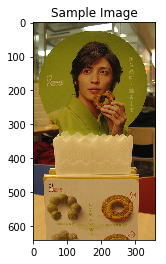

a woman holding a doughnut in her hand .


In [16]:
get_prediction()

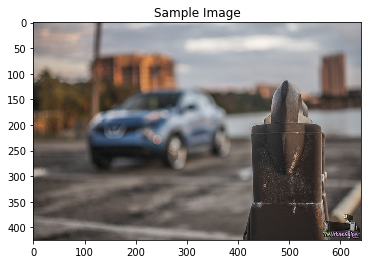

a person holding a surf board on a street .


In [17]:
get_prediction()

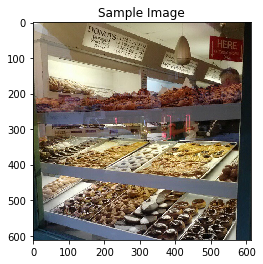

a table topped with a pizza and a box of pizza .


In [18]:
get_prediction()

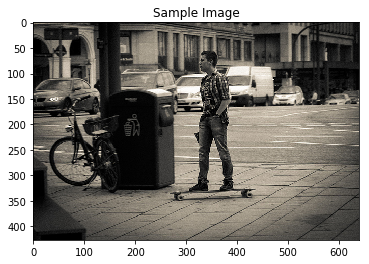

a man standing on a sidewalk in front of a building .


In [19]:
get_prediction()

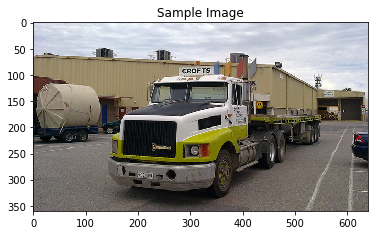

a truck is parked in a parking lot .


In [20]:
get_prediction()

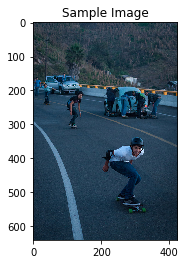

a group of people on a motorcycle with a dog .


In [21]:
get_prediction()

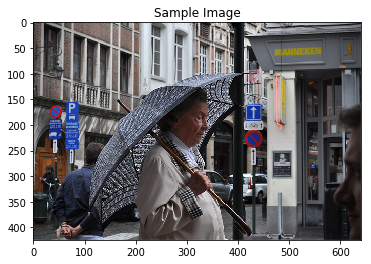

a woman holding an umbrella standing on a sidewalk .


In [22]:
get_prediction()

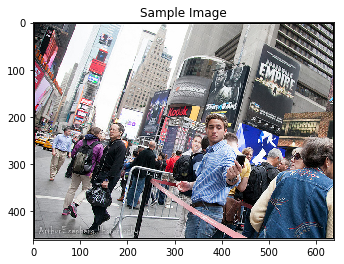

a group of people standing around a table with a laptop .


In [23]:
get_prediction()

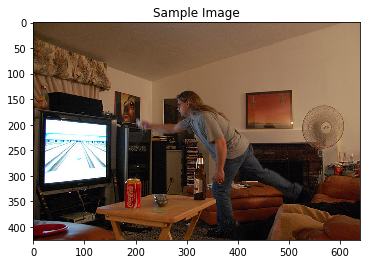

a man is playing a video game in a living room .


In [24]:
get_prediction()

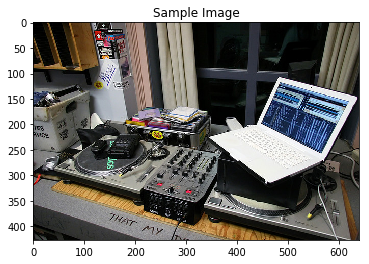

a laptop computer sitting on top of a desk .


In [25]:
get_prediction()

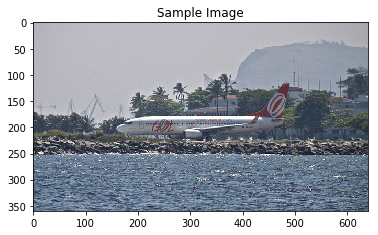

a large jetliner flying over a large body of water .


In [26]:
get_prediction()

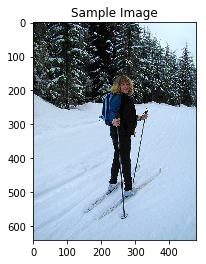

a man is standing in the snow with a snowboard .


In [27]:
get_prediction()

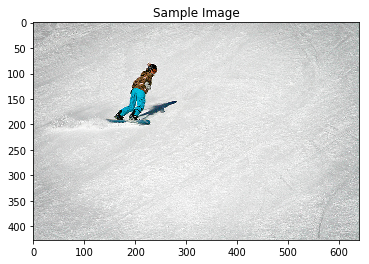

a person riding a snowboard down a snow covered slope .


In [28]:
get_prediction()

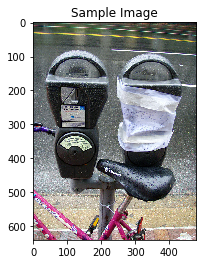

a person holding a cell phone to a car


In [29]:
get_prediction()

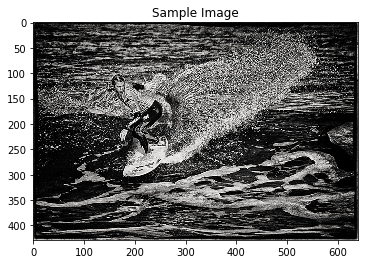

a man is standing on a boat in the water .


In [30]:
get_prediction()

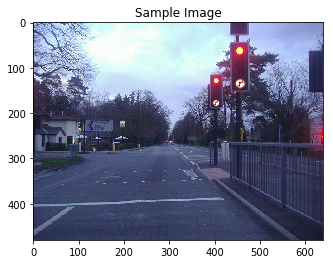

a traffic light on a busy street in the city .


In [31]:
get_prediction()